# Finetune ResNet50


With 1000 x 400 melspectrogram images (resized and padded) without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:

FINETUNED_MODEL = 'resnet50_resizepad'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Import ResizePad


In [14]:
from transforms.ResizePad import ResizePad

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    ResizePad(size=(224, 224)),  # Maintain aspect ratio then pad
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.89it/s, Loss=1.4825842380523682, Elapsed=20.4641s, ETA=0.0000s] 


Epoch 1 completed in 73.7872s
Train Loss: 1.496411820712117 - Train Accuracy: 40.58931276995093
Validation Loss: 1.3587219826380412 - Validation Accuracy: 46.49641198818067

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.91it/s, Loss=1.4448829889297485, Elapsed=20.1943s, ETA=0.0000s] 


Epoch 2 completed in 73.9009s
Train Loss: 1.3424757698367786 - Train Accuracy: 46.76285022952896
Validation Loss: 1.381276888847351 - Validation Accuracy: 46.08484592655129

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.78it/s, Loss=1.2661316394805908, Elapsed=20.2920s, ETA=0.0000s] 


Epoch 3 completed in 72.5429s
Train Loss: 1.2994023585595147 - Train Accuracy: 48.827480156486736
Validation Loss: 1.31989466826121 - Validation Accuracy: 48.9341494301393

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.93it/s, Loss=1.362868070602417, Elapsed=20.2105s, ETA=0.0000s]  


Epoch 4 completed in 72.9922s
Train Loss: 1.2713186193063768 - Train Accuracy: 50.188824314239845
Validation Loss: 1.2740217502911886 - Validation Accuracy: 50.189953566905864

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.98it/s, Loss=1.4803433418273926, Elapsed=20.1890s, ETA=0.0000s] 


Epoch 5 completed in 72.9086s
Train Loss: 1.253554622906481 - Train Accuracy: 50.831053119558575
Validation Loss: 1.2700736443201701 - Validation Accuracy: 50.61207260447447

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.89it/s, Loss=1.4576784372329712, Elapsed=20.3409s, ETA=0.0000s] 


Epoch 6 completed in 72.3121s
Train Loss: 1.2421090289347434 - Train Accuracy: 51.45066823454919
Validation Loss: 1.249493731657664 - Validation Accuracy: 51.857323765301814

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.84it/s, Loss=1.1103992462158203, Elapsed=20.7525s, ETA=0.0000s] 


Epoch 7 completed in 73.2603s
Train Loss: 1.2297090829452337 - Train Accuracy: 51.923294362407
Validation Loss: 1.284221384525299 - Validation Accuracy: 50.35880118193331

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.98it/s, Loss=1.1875649690628052, Elapsed=20.0454s, ETA=0.0000s] 


Epoch 8 completed in 72.3845s
Train Loss: 1.2198381031179704 - Train Accuracy: 52.443409239953866
Validation Loss: 1.2419535462061564 - Validation Accuracy: 51.762346981848886

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.01it/s, Loss=1.2314906120300293, Elapsed=19.9771s, ETA=0.0000s] 


Epoch 9 completed in 71.6271s
Train Loss: 1.2109628312849585 - Train Accuracy: 52.93186495104136
Validation Loss: 1.2559946695963542 - Validation Accuracy: 51.05529759392149

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.97it/s, Loss=1.4407099485397339, Elapsed=20.1203s, ETA=0.0000s] 


Epoch 10 completed in 71.9639s
Train Loss: 1.2049774183014226 - Train Accuracy: 53.25750209176635
Validation Loss: 1.2294351665178935 - Validation Accuracy: 52.65934993668214

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.77it/s, Loss=1.1525204181671143, Elapsed=21.2284s, ETA=0.0000s]  


Epoch 11 completed in 73.2114s
Train Loss: 1.2001350096539956 - Train Accuracy: 53.45197982858822
Validation Loss: 1.2483756605784098 - Validation Accuracy: 51.02363866610384

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.95it/s, Loss=1.5190236568450928, Elapsed=20.0929s, ETA=0.0000s] 


Epoch 12 completed in 72.4051s
Train Loss: 1.1907921674623654 - Train Accuracy: 53.88616268288822
Validation Loss: 1.2205019156138102 - Validation Accuracy: 53.29252849303504

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.99it/s, Loss=1.4022568464279175, Elapsed=20.0183s, ETA=0.0000s] 


Epoch 13 completed in 72.0266s
Train Loss: 1.1827771296735443 - Train Accuracy: 54.238936252006965
Validation Loss: 1.2399134691556295 - Validation Accuracy: 52.07893626002533

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s, Loss=1.185206651687622, Elapsed=20.1952s, ETA=0.0000s]  


Epoch 14 completed in 72.1278s
Train Loss: 1.1787031112034196 - Train Accuracy: 54.2457203591054
Validation Loss: 1.2063417013486226 - Validation Accuracy: 53.27142254115661

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.82it/s, Loss=1.3417704105377197, Elapsed=20.2557s, ETA=0.0000s] 


Epoch 15 completed in 72.1833s
Train Loss: 1.1667741823058597 - Train Accuracy: 54.84498315280071
Validation Loss: 1.206416966120402 - Validation Accuracy: 53.704094554664415

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.01it/s, Loss=1.2369825839996338, Elapsed=19.9808s, ETA=0.0000s] 


Epoch 16 completed in 72.4887s
Train Loss: 1.1731999998836848 - Train Accuracy: 54.26607268040071
Validation Loss: 1.1950369000434875 - Validation Accuracy: 53.98902490502322

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.98it/s, Loss=1.1278915405273438, Elapsed=20.0970s, ETA=0.0000s] 


Epoch 17 completed in 72.0074s
Train Loss: 1.1599714016983276 - Train Accuracy: 55.22941588837883
Validation Loss: 1.2000897383689881 - Validation Accuracy: 53.72520050654285

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.97it/s, Loss=1.4786012172698975, Elapsed=20.1088s, ETA=0.0000s] 


Epoch 18 completed in 71.7455s
Train Loss: 1.1522034416998053 - Train Accuracy: 55.482689220053814
Validation Loss: 1.1967475136121115 - Validation Accuracy: 54.115660616293795

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.98it/s, Loss=1.3131707906723022, Elapsed=20.0924s, ETA=0.0000s] 


Epoch 19 completed in 71.7685s
Train Loss: 1.1463820405433633 - Train Accuracy: 55.76762171818819
Validation Loss: 1.2222064558664958 - Validation Accuracy: 52.24778387505277

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.79it/s, Loss=1.4776737689971924, Elapsed=20.3702s, ETA=0.0000s] 


Epoch 20 completed in 72.0338s
Train Loss: 1.1474986367487494 - Train Accuracy: 55.53922344587413
Validation Loss: 1.2086186854044596 - Validation Accuracy: 53.419164204305616

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.00it/s, Loss=1.3375325202941895, Elapsed=20.0310s, ETA=0.0000s] 


Epoch 21 completed in 71.7718s
Train Loss: 1.1429056971403904 - Train Accuracy: 55.896519753058506
Validation Loss: 1.1918550435702007 - Validation Accuracy: 54.78049810046433

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.83it/s, Loss=1.0926295518875122, Elapsed=20.1961s, ETA=0.0000s] 


Epoch 22 completed in 71.8332s
Train Loss: 1.1398321007717551 - Train Accuracy: 56.059338323421
Validation Loss: 1.1854071235656738 - Validation Accuracy: 53.936260025327144

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.98it/s, Loss=1.4807794094085693, Elapsed=20.3494s, ETA=0.0000s] 


Epoch 23 completed in 72.1970s
Train Loss: 1.1336366740954404 - Train Accuracy: 56.378191357047555
Validation Loss: 1.2133672245343525 - Validation Accuracy: 54.0523427606585

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.02it/s, Loss=1.4116661548614502, Elapsed=20.0748s, ETA=0.0000s] 


Epoch 24 completed in 72.0856s
Train Loss: 1.1301848278569349 - Train Accuracy: 56.32844123832568
Validation Loss: 1.1884224025408427 - Validation Accuracy: 54.485014774166316

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.03it/s, Loss=1.473633050918579, Elapsed=20.1394s, ETA=0.0000s]  

Epoch 25 completed in 71.8543s
Train Loss: 1.124294993849848 - Train Accuracy: 57.092783971416296
Validation Loss: 1.1870700438817343 - Validation Accuracy: 54.53777965386239



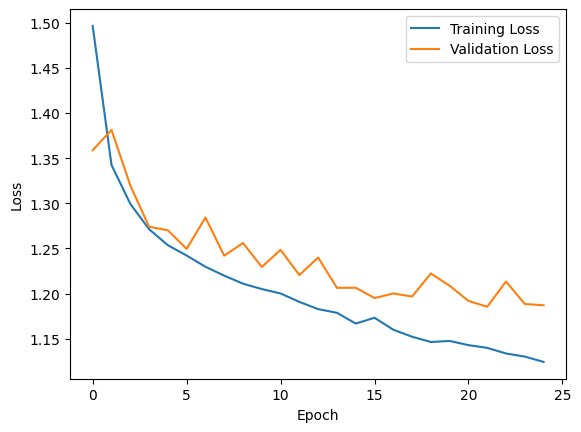

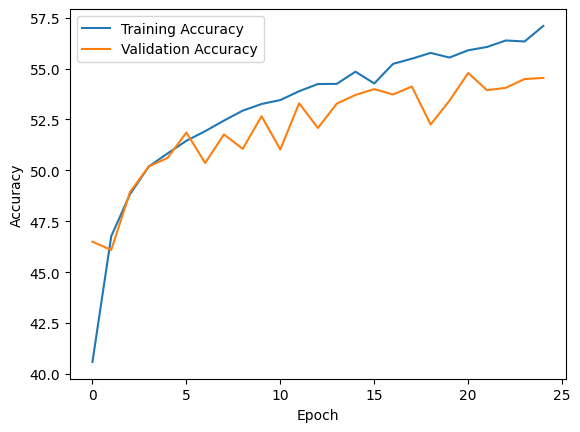

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [18]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_7896\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:20<00:00,  3.59it/s]


Test Results (Best Model):
Test Loss: 1.1932
Test Accuracy: 53.37%


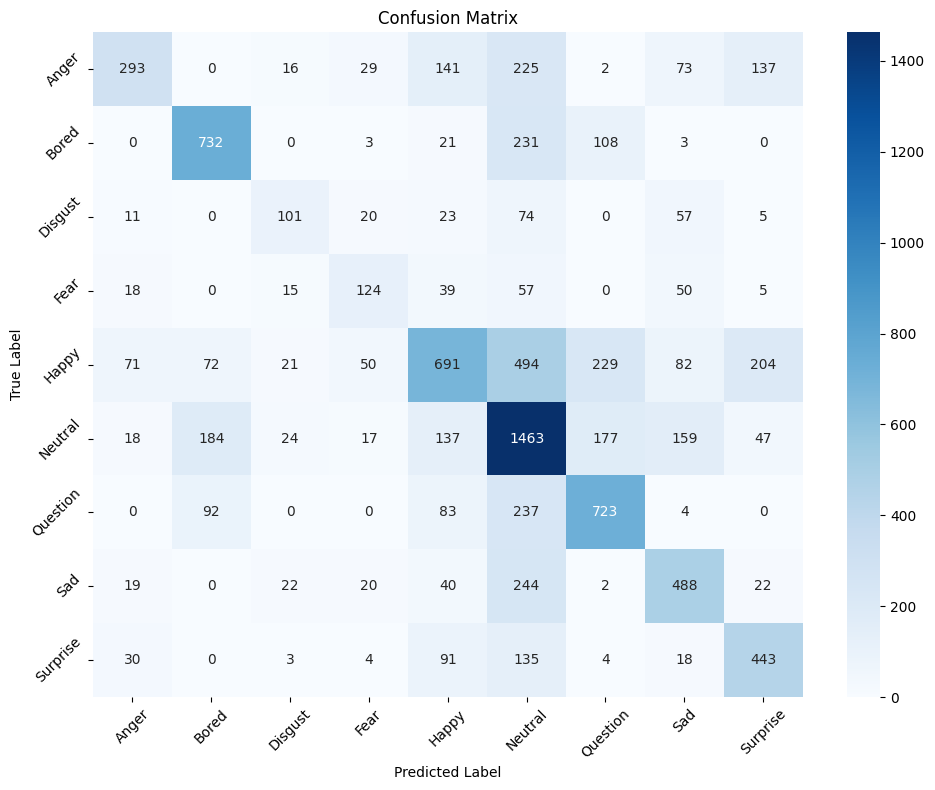

In [19]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)